## 4. 감정 분류 + 시각화

In [3]:
#import os
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
from ultralytics import YOLO
from torch import nn

# 클래스 이름
class_names = ['분노', '기쁨', '당황', '슬픔']

# 전처리 transform
data_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

import torch
import torch.nn as nn
from torchvision import models

class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # EfficientNet-b0 불러오기 (사전학습)
        base_model = models.efficientnet_b3(pretrained=True)

        # Feature extractor 부분만 사용
        self.features = base_model.features  # (batch, 1280, 7, 7)

        # Adaptive Pooling 추가 (출력 크기 맞추기)
        self.pooling = nn.AdaptiveAvgPool2d(1)  # (batch, 1280, 1, 1)

        # Classifier 정의
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # (batch, 1280)
            nn.Linear(1536, 128),            # EfficientNet-b0의 feature dim = 1280
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)     # (B, 1280, 7, 7)
        x = self.pooling(x)      # (B, 1280, 1, 1)
        x = self.classifier(x)   # (B, num_classes)
        return x


In [ ]:
# 자동화 파이프라인 함수
def detect_and_classify(image_path, yolo_model_path, classifier_path):
    # 1. 얼굴 탐지
    yolo_model = YOLO(yolo_model_path)
    image = Image.open(image_path).convert("RGB")
    results = yolo_model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()

    #요건 커스텀일 경우?
    classifier = EmotionClassifier(num_classes=4)  #Pre
    classifier.load_state_dict(torch.load('/workspace/yoons/emotion_classifier11_aug_eff_b3_data_added_2.pth', map_location=device))
    classifier.eval()

    # 3. 탐지된 얼굴 순회하며 감정 분류
    predictions = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        face_crop = image.crop((x1, y1, x2, y2))
        face_tensor = data_transform(face_crop).unsqueeze(0)

        with torch.no_grad():
            output = classifier(face_tensor)
            prob = torch.softmax(output, dim=1)
            class_idx = torch.argmax(prob)

        predictions.append({
            'box': (x1, y1, x2, y2),
            'emotion': class_names[class_idx],
            'confidence': prob[0][class_idx].item()
        })

    return predictions

In [ ]:
# 결과
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if __name__ == "__main__":
    result = detect_and_classify(
        image_path="/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg",
        yolo_model_path="/workspace/yoons/runs/detect/train/weights/best.onnx",
        classifier_path='/workspace/yoons/emotion_classifier11_aug_eff_b3_data_added_2.pth'
    )

    for i, r in enumerate(result):
        print(f"Face {i+1}: 감정 = {r['emotion']}, 확신도 = {r['confidence']:.2f}, 박스 = {r['box']}")


Loading /workspace/yoons/runs/detect/train/weights/best.onnx for ONNX Runtime inference...


Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 기쁨, 1 당황, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


2025-07-08 21:56:00.698546741 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


Face 1: 감정 = 기쁨, 확신도 = 0.56, 박스 = (109, 80, 204, 204)
Face 2: 감정 = 당황, 확신도 = 0.94, 박스 = (183, 188, 273, 319)


In [85]:
!apt-get install fonts-nanum -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 105 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7924 kB/s)      
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 36563 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [86]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 또는 사용할 한글 폰트 경로
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)


In [118]:
%matplotlib inline


In [99]:
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_results(image_path, results,
                      font_size=48,
                      box_color=(0, 255, 0),
                      thickness=5,
                      font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"):
    # 원본 이미지 (BGR → RGB)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # PIL 이미지로 변환
    pil_img = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_img)

    # 한글 지원 폰트 (경로는 환경에 따라 조정)
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print("⚠️ 한글 폰트를 불러올 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()

    # 박스 및 텍스트 그리기
    for res in results:
        x1, y1, x2, y2 = map(int, res["box"])
        label = f"{res['emotion']} ({res['confidence']:.2f})"

        # 박스 (OpenCV)
        image = cv2.rectangle(np.array(pil_img), (x1, y1), (x2, y2), (0, 255, 0), 2)
        pil_img = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_img)

        # 텍스트 (PIL, 한글 지원)
        draw.text((x1, y1 - (font_size+10)), label, font=font, fill=(0, 255, 0))

    # 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.title("Emotion Detection Results")
    plt.show()

Loading /workspace/yoons/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider



0: 640x640 1 기쁨, 1 당황, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


Face 1: 감정 = 기쁨, 확신도 = 0.51, 박스 = (109, 80, 204, 204)
Face 2: 감정 = 슬픔, 확신도 = 0.35, 박스 = (183, 188, 273, 319)


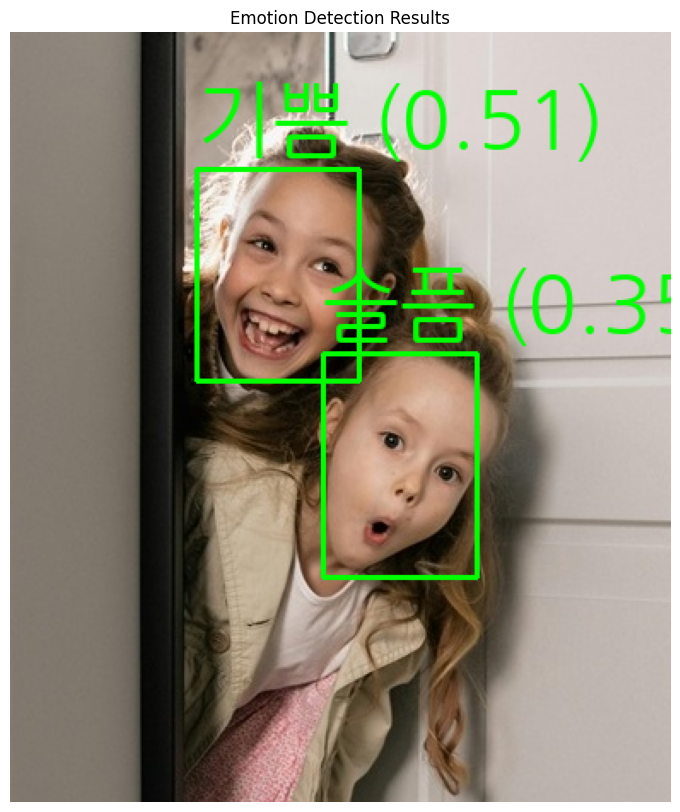

In [ ]:
# 결과 출력 + 시각화
if __name__ == "__main__":
    result = detect_and_classify(
        image_path="/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg",
        yolo_model_path="/workspace/yoons/runs/detect/train/weights/best.onnx",
        classifier_path='/workspace/yoons/emotion_classifier11_aug_eff_b3_data_added_2.pth'
    )

    for i, r in enumerate(result):
        print(f"Face {i+1}: 감정 = {r['emotion']}, 확신도 = {r['confidence']:.2f}, 박스 = {r['box']}")

    # 시각화 함수 호출
    visualize_results("/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg", result)





###아래는 확률 % 보여주도록 하기

In [101]:
#확률로 보여주기 ... 차트 기능 포함하도록
import torch.nn.functional as F

def detect_and_classify2(image_path, yolo_model_path, classifier_path, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load YOLO 모델
    yolo = YOLO(yolo_model_path)

    # Load 감정 분류기
    classifier = EmotionClassifier()
    classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    classifier = classifier.to(device)
    classifier.eval()

    # 이미지 로드 및 YOLO 탐지
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = yolo(img_rgb)[0]

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    result_list = []
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        conf = float(box.conf[0])

        # 얼굴 영역 크롭
        face_crop = img_rgb[y1:y2, x1:x2]
        if face_crop.size == 0:
            continue  # 빈 영역이면 스킵

        face_pil = Image.fromarray(face_crop)
        face_tensor = transform(face_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = classifier(face_tensor)
            probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
            top1 = int(probs.argmax())
            emotion = class_names[top1] if class_names else str(top1)
            confidence = float(probs[top1])
            prob_dict = {class_names[i]: float(p) for i, p in enumerate(probs)} if class_names else None

        result_list.append({
            "box": [x1, y1, x2, y2],
            "emotion": emotion,
            "confidence": confidence,
            "probs": probs.tolist(),       # ✔ bar chart 용
            "all_probs": prob_dict         # ✔ 텍스트 출력용
        })

    return result_list


In [ ]:
class_names = ['분노', '기쁨', '당황', '슬픔']

result = detect_and_classify2(
    image_path="/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg",
    yolo_model_path="/workspace/yoons/runs/detect/train/weights/best.onnx",
    classifier_path='/workspace/yoons/emotion_classifier11_aug_eff_b3_data_added_2.pth',
    class_names=class_names
)

for i, r in enumerate(result):
    print(f"Face {i+1}: 감정 = {r['emotion']} ({r['confidence']:.2f})")
    for emo, prob in r['all_probs'].items():
        print(f"   {emo}: {prob:.2f}")


Loading /workspace/yoons/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 기쁨, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Face 1: 감정 = 기쁨 (0.48)
   분노: 0.07
   기쁨: 0.48
   당황: 0.41
   슬픔: 0.04


In [105]:
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_results2(image_path, results,
                      box_color=(0, 255, 0),
                      font_size=48,  # ⬅️ 글씨 크기 조정
                      thickness=2,
                      font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"):
    # 이미지 로드 및 RGB 변환
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # PIL 이미지로 변환
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)

    # 폰트 로드 (크기 조정 가능)
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print("⚠️ 폰트 로드 실패, 기본 폰트로 대체합니다.")
        font = ImageFont.load_default()

    for r in results:
        x1, y1, x2, y2 = r["box"]
        emotion = r["emotion"]
        conf = r["confidence"]
        label = f"{emotion} ({conf:.2f})"

        # OpenCV로 바운딩 박스 그리기
        img_cv = np.array(pil_img)
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), box_color, thickness)
        pil_img = Image.fromarray(img_cv)
        draw = ImageDraw.Draw(pil_img)

        # 텍스트 배경 상자
        text_bbox = draw.textbbox((x1, y1), label, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]
        draw.rectangle([(x1, y1 - text_h - 4), (x1 + text_w, y1)], fill=box_color)

        # 텍스트 표시 (한글 지원)
        #draw.text((x1, y1 - text_h - 2), label, font=font, fill=(0, 0, 0))
        draw.text((x1, y1 - (font_size+10)), label, font=font, fill=(0, 0, 0))

    # 출력
    plt.figure(figsize=(10, 8))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.show()


Loading /workspace/yoons/runs/detect/train/weights/best.onnx for ONNX Runtime inference...


Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 기쁨, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


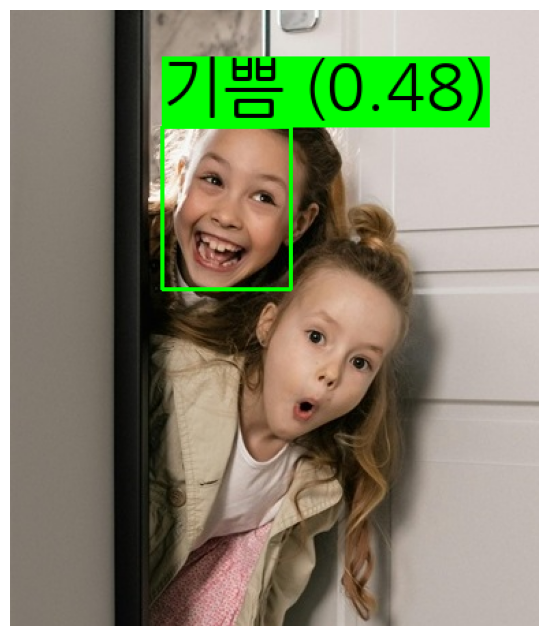

In [ ]:
result = detect_and_classify2(
    image_path="/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg",
    yolo_model_path="/workspace/yoons/runs/detect/train/weights/best.onnx",
    classifier_path='/workspace/yoons/emotion_classifier11_aug_eff_b3_data_added_2.pth',
    class_names=['분노', '기쁨', '당황', '슬픔']
)

visualize_results2("pexels-a-darmel-7642207sm_cr.jpg", result)


In [107]:
result

[{'box': [111, 85, 205, 204],
  'emotion': '기쁨',
  'confidence': 0.4812614917755127,
  'probs': [0.06884826719760895,
   0.4812614917755127,
   0.4092771112918854,
   0.04061317816376686],
  'all_probs': {'분노': 0.06884826719760895,
   '기쁨': 0.4812614917755127,
   '당황': 0.4092771112918854,
   '슬픔': 0.04061317816376686}}]

In [108]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_results_with_probs(image_path, results, class_names,
                            box_color=(0, 255, 0),
                            font_size=26,
                            font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"):
    # 이미지 열기
    pil_img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(pil_img)

    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print("⚠️ 폰트 로드 실패, 기본 폰트로 대체합니다.")
        font = ImageFont.load_default()

    for result in results:
        x1, y1, x2, y2 = map(int, result['box'])
        emotion = result['emotion']
        confidence = result['confidence']
        probs = result.get('all_probs', {})  # softmax 확률 딕셔너리

        # 바운딩 박스 그리기
        draw.rectangle([(x1, y1), (x2, y2)], outline=box_color, width=3)

        # 라벨 텍스트 (한글 포함)
        label = f"{emotion} ({confidence:.2f})"
        #draw.text((x1, y1 - font_size - 4), label, font=font, fill=(255, 0, 0))

        # 텍스트 배경 상자
        text_bbox = draw.textbbox((x1, y1), label, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]
        draw.rectangle([(x1, y1 - (font_size+10)), (x1 + text_w, y1)], fill=box_color)

        # 텍스트 표시 (한글 지원)
        #draw.text((x1, y1 - text_h - 2), label, font=font, fill=(0, 0, 0))
        draw.text((x1, y1 - (font_size+10)), label, font=font, fill=(0, 0, 0))

        # 확률 막대 그래프
        bar_x = x1
        bar_y = y2 + 14
        bar_width = 200
        bar_height = 25
        spacing = 32

        for i, class_name in enumerate(class_names):
            prob = probs.get(class_name, 0)
            bar_len = int(bar_width * prob)

            # 막대
            draw.rectangle([(bar_x, bar_y + i * spacing),
                            (bar_x + bar_len, bar_y + i * spacing + bar_height)],
                           fill=(100, 100, 255))

            # 클래스명 + 확률 텍스트
            prob_label = f"{class_name} {prob:.2f}"
            draw.text((bar_x + bar_width + 10, bar_y + i * spacing), prob_label,
                      font=font, fill=(0, 0, 0))

    # 최종 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(pil_img)
    plt.axis('off')
    plt.show()


In [109]:
result

[{'box': [111, 85, 205, 204],
  'emotion': '기쁨',
  'confidence': 0.4812614917755127,
  'probs': [0.06884826719760895,
   0.4812614917755127,
   0.4092771112918854,
   0.04061317816376686],
  'all_probs': {'분노': 0.06884826719760895,
   '기쁨': 0.4812614917755127,
   '당황': 0.4092771112918854,
   '슬픔': 0.04061317816376686}}]

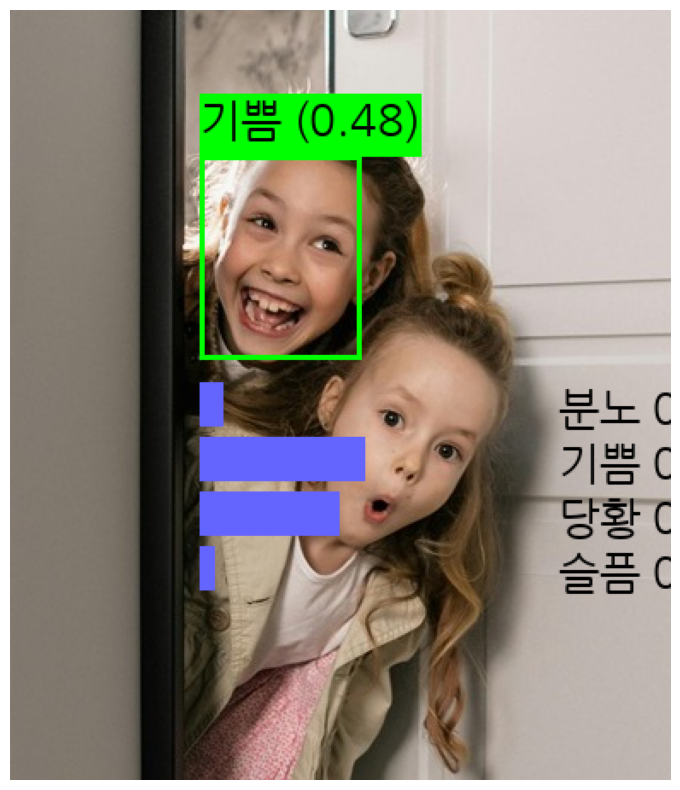

In [121]:
draw_results_with_probs("pexels-a-darmel-7642207sm_cr.jpg", result, class_names=['분노', '기쁨', '당황', '슬픔'])
